原始数据列名: ['date', 'open', 'high', 'low', 'close', 'volume', 'hold', 'settle']
数据前5行:
         date    open    high     low   close  volume  hold  settle
0  2025-09-22  4492.8  4499.8  4460.6  4493.4    2045  1918     0.0
1  2025-09-23  4502.0  4523.6  4425.2  4495.4    3869  2866     0.0
2  2025-09-24  4476.6  4541.4  4476.6  4541.4    4583  4474     0.0
3  2025-09-25  4533.2  4596.6  4533.2  4571.2    2872  4008     0.0
4  2025-09-26  4558.6  4579.4  4531.8  4532.4    3254  4375     0.0

清洗后数据信息:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39 entries, 2025-09-22 to 2025-11-21
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    39 non-null     float64
 1   high    39 non-null     float64
 2   low     39 non-null     float64
 3   close   39 non-null     float64
 4   volume  39 non-null     int64  
 5   hold    39 non-null     int64  
 6   settle  39 non-null     float64
dtypes: float64(5), int64(2)
memory usage: 

E:\AppData\ipykernel_5488\1233114677.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


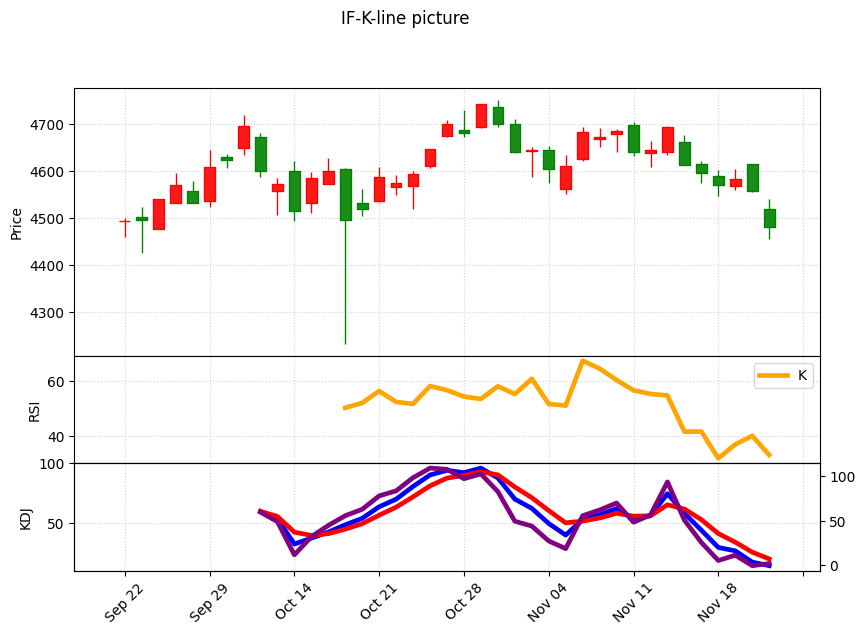

In [3]:
"""
接口: futures_zh_daily_sina

目标地址: https://finance.sina.com.cn/futures/quotes/V2105.shtml

描述: 新浪财经-期货-日频数据

限量: 单次返回指定 symbol 的所有日频数据; 期货连续合约为 品种代码+0，比如螺纹钢连续合约为 RB0;

输入参数

名称	类型	描述
symbol	str	symbol="RB0"; 具体合约可以通过 ak.match_main_contract(symbol="shfe") 获取或者访问网页
输出参数

名称	类型	描述
date	object	-
open	float64	开盘价
high	float64	最高价
low	    float64	最低价
close	float64	收盘价
volume	int64	成交量
hold	int64	持仓量
settle	float64	结算价

"""


import akshare as ak
import mplfinance as mpf
import pandas as pd
from matplotlib import pyplot as plt


# 步骤1：获取K线数据
def get_futures_data():
    """
    从AKShare获取股票日K线数据
    """
    df = ak.futures_zh_daily_sina(symbol="IF2511")
    try:
        if df is None or df.empty:
            print("获取数据失败")
            exit(1)
        return df
    except Exception as e:
        print(f"获取数据时出错: {str(e)[:100]}")
        return None

df = get_futures_data()

print("原始数据列名:", df.columns.tolist())
print("数据前5行:")
print(df.head())

# 步骤2：数据清洗和格式化


# 清洗数据
def clean_data(df):
    """
    清洗数据，转换为mplfinance需要的格式
    """
    # 不需要重命名，直接使用原始列名
    # 确保日期列为datetime类型并设为索引
    df['date'] = pd.to_datetime(df['date']) 
    df = df.set_index('date')  
    
    # 确保数值列是数字类型
    numeric_columns = ['open', 'high', 'low', 'close', 'volume']  
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 按日期排序
    df = df.sort_index()
    
    return df

df_clean = clean_data(df)
print("\n清洗后数据信息:")
print(df_clean.info())

# 步骤3：计算技术指标函数
def calculate_rsi(prices, period=14):
    """计算RSI指标"""
    delta = prices.diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / (loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_kdj(df, n=9, m1=3, m2=3):
    """计算KDJ指标"""
    low_list = df['low'].rolling(window=n).min()
    high_list = df['high'].rolling(window=n).max()
    
    rsv = (df['close'] - low_list) / (high_list - low_list + 1e-10) * 100
    k = rsv.ewm(span=m1).mean()
    d = k.ewm(span=m2).mean()
    j = 3 * k - 2 * d
    
    return k, d, j

df_clean['RSI'] = calculate_rsi(df_clean['close'])
df_clean['K'], df_clean['D'], df_clean['J'] = calculate_kdj(df_clean)

# ---------------------- 关键：先配置中文显示（必须放在绘图前）----------------------
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows用（黑体），Mac/Linux换对应字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示方框问题

#步骤4：作图
def plot_with_mplfinance(df):
    """
    使用mplfinance绘制K线图
    """
    # 创建自定义样式
    mc = mpf.make_marketcolors(
        up='red',      # 上涨为红色
        down='green',  # 下跌为绿色
        edge='inherit',
        wick='inherit',
        volume='in'
    )
    
    style = mpf.make_mpf_style(
        marketcolors=mc,
        gridstyle=':',  # 网格线样式
        gridcolor='lightgray',
        facecolor='white'
    )
    
    # 准备副图数据
    apds = [
        # RSI副图
        mpf.make_addplot(df['RSI'], panel=1, color='orange', ylabel='RSI'),#面板，颜色，ylabel轴名
        # KDJ副图（K线）
        mpf.make_addplot(df['K'], panel=2, color='blue', ylabel='KDJ'),
        # KDJ副图（D线）
        mpf.make_addplot(df['D'], panel=2, color='red'),
        # KDJ副图（J线）
        mpf.make_addplot(df['J'], panel=2, color='purple'),
    ]
    
    # 绘制图表
    fig, axes = mpf.plot(
        df,
        type='candle',           # K线类型：蜡烛图
        style=style,            # 样式
        addplot=apds,          # 副图指标
        volume=False,           # 不显示成交量
        title='IF-K-line picture',  # 标题
        ylabel='Price',          # Y轴标签
        #ylabel_lower='Trading volume',   # 成交量Y轴标签
        figratio=(12, 8),      # 图表比例
        figscale=1.2,          # 图表缩放
        returnfig=True         # 返回figure对象以便进一步定制
    )
    
    # 添加RSI参考线
    axes[1].axhline(y=70, color='red', linestyle='--', alpha=0.7)
    axes[1].axhline(y=30, color='green', linestyle='--', alpha=0.7)
    axes[1].legend(['RSI(14)', '超买线(70)', '超卖线(30)'])
    
    # 添加KDJ图例
    axes[2].legend(['K', 'D', 'J'])
    
    # 调整布局
    plt.tight_layout()
    plt.show()
    
# 绘制图表
plot_with_mplfinance(df_clean.tail(50))  # 只显示最近100个交易日

